In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install tensorflow-addons

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
#import tensorflow_addons as tfa
from imutils import paths
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import matplotlib.pyplot as plt
#matplotlib.use("Agg")
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight




## Qual GPU está sendo usada

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Dec 28 09:44:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
BS = 32
img_height = 128
img_width = 128

INIT_LR = 0.001
EPOCHS = 300

SEED = 42

In [ ]:
train_dir = "/content/drive/My Drive/mosquitoes-datasets/parted/base03/train"
validation_dir = "/content/drive/My Drive/mosquitoes-datasets/parted/base03/validation"
test_dir = "/content/drive/My Drive/mosquitoes-datasets/parted/base03/test"

In [ ]:
	train_datagen = ImageDataGenerator(
    rescale=1./255,
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest",)

In [ ]:
    val_datagen = ImageDataGenerator(
    rescale=1./255,)

In [ ]:
    test_datagen = ImageDataGenerator(
    rescale=1./255,)

In [ ]:
train_ds = train_datagen.flow_from_directory(
  directory = train_dir,
  target_size=(img_height, img_width),
  batch_size=BS,
  seed=SEED,
  class_mode='categorical',)

Found 3802 images belonging to 6 classes.


In [ ]:
val_ds = val_datagen.flow_from_directory(
  directory = validation_dir,
  target_size=(img_height, img_width),
  batch_size=BS,
  seed=SEED,
  class_mode='categorical',)


Found 815 images belonging to 6 classes.


In [ ]:
test_ds = test_datagen.flow_from_directory(
  directory = test_dir,
  target_size=(img_height, img_width),
  batch_size=BS,
  shuffle=False,
  seed=SEED,
  class_mode='categorical',)


Found 815 images belonging to 6 classes.


In [ ]:
class_names = train_ds.class_indices
print(class_names)

{'aae-femea': 0, 'aae-macho': 1, 'aal-femea': 2, 'aal-macho': 3, 'cq-femea': 4, 'cq-macho': 5}


In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / EPOCHS)


In [ ]:
class_weights = class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_ds.classes), 
            y = train_ds.classes)

train_class_weights = dict(enumerate(class_weights))

In [ ]:
train_class_weights

{0: 0.9052380952380953,
 1: 0.9052380952380953,
 2: 1.309228650137741,
 3: 1.2232947232947233,
 4: 0.9052380952380953,
 5: 0.9052380952380953}

In [ ]:
model = tf.keras.applications.ResNet50(include_top=True,
                                             weights=None,
                                             input_shape=(img_height,img_width,3),
                                             classes=6)

In [ ]:
model.compile(loss=loss_fn,optimizer = opt, metrics = ['accuracy'])

In [ ]:
# simple early stopping 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
import time
inicio = time.process_time()

H = model.fit(train_ds,batch_size=BS,
              validation_data=val_ds,
              class_weight=train_class_weights,
              epochs=EPOCHS,
              callbacks=[es])

fim = time.process_time()
tempo = fim - inicio

Epoch 1/300
119/119 [==============================] - 1948s 16s/step - loss: 1.5126 - accuracy: 0.3966 - val_loss: 2.3447 - val_accuracy: 0.1840
Epoch 2/300
119/119 [==============================] - 59s 494ms/step - loss: 1.2414 - accuracy: 0.5142 - val_loss: 6.0902 - val_accuracy: 0.1840
Epoch 3/300
119/119 [==============================] - 58s 491ms/step - loss: 0.9603 - accuracy: 0.6120 - val_loss: 4.2736 - val_accuracy: 0.3301
Epoch 4/300
119/119 [==============================] - 58s 491ms/step - loss: 0.8458 - accuracy: 0.6749 - val_loss: 1.4796 - val_accuracy: 0.4871
Epoch 5/300
119/119 [==============================] - 59s 493ms/step - loss: 0.8416 - accuracy: 0.6944 - val_loss: 0.7186 - val_accuracy: 0.7215
Epoch 6/300
119/119 [==============================] - 59s 495ms/step - loss: 0.7315 - accuracy: 0.7283 - val_loss: 0.9420 - val_accuracy: 0.6613
Epoch 7/300
119/119 [==============================] - 58s 491ms/step - loss: 0.7494 - accuracy: 0.7244 - val_loss: 0.7892 -

In [ ]:
tempo

3532.821667713

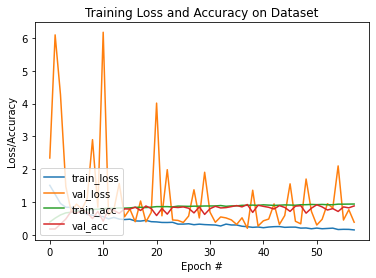

In [ ]:
if es.stopped_epoch!=0:
  EPOCHS = es.stopped_epoch+1

  
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
#plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot.png")
plt.show()

##Teste

## Get the accuracy score

In [ ]:
test_score = model.evaluate(test_ds)



print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 

print("[INFO] Loss: ",test_score[0])

26/26 [==============================] - 10s 389ms/step - loss: 0.4984 - accuracy: 0.8736
[INFO] accuracy: 87.36%
[INFO] Loss:  0.49837610125541687


## Plot the confusion matrix. Set Normalize = True/False

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

## Print the Target names

In [ ]:
target_names = []

for key in train_ds.class_indices:

    target_names.append(key)



print(target_names)

['aae-femea', 'aae-macho', 'aal-femea', 'aal-macho', 'cq-femea', 'cq-macho']


## Confution Matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Confusion Matrix
Confusion matrix, without normalization


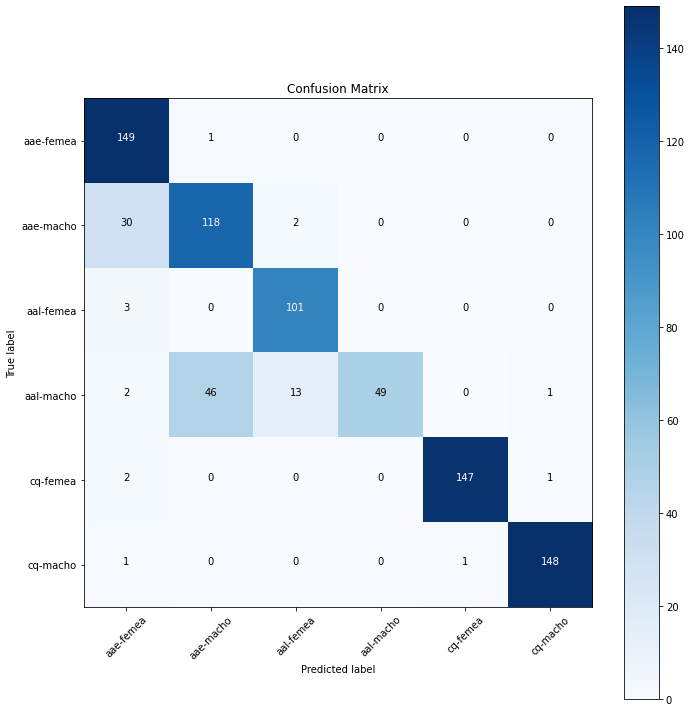

In [ ]:
Y_pred = model.predict_generator(test_ds)

y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(test_ds.classes, y_pred)

plot_confusion_matrix(cm, target_names, False, title='Confusion Matrix')

## Print Classification Report

In [ ]:
print('Classification Report')

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   aae-femea       0.80      0.99      0.88       150
   aae-macho       0.72      0.79      0.75       150
   aal-femea       0.87      0.97      0.92       104
   aal-macho       1.00      0.44      0.61       111
    cq-femea       0.99      0.98      0.99       150
    cq-macho       0.99      0.99      0.99       150

    accuracy                           0.87       815
   macro avg       0.89      0.86      0.86       815
weighted avg       0.89      0.87      0.86       815



In [ ]:
'''#Retrieve a batch of images from the test set
image_batch, label_batch = test_norm_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")'''

'#Retrieve a batch of images from the test set\nimage_batch, label_batch = test_norm_ds.as_numpy_iterator().next()\npredictions = model.predict_on_batch(image_batch).flatten()\n\n# Apply a sigmoid since our model returns logits\n#predictions = tf.nn.sigmoid(predictions)\npredictions = tf.where(predictions < 0.5, 0, 1)\n\nprint(\'Predictions:\n\', predictions.numpy())\nprint(\'Labels:\n\', label_batch)\n\nplt.figure(figsize=(10, 10))\nfor i in range(9):\n  ax = plt.subplot(3, 3, i + 1)\n  plt.imshow(image_batch[i].astype("uint8"))\n  plt.title(class_names[predictions[i]])\n  plt.axis("off")'

## Serialize model to JSON

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk
